# <p style="text-align: center;"> Social Butterfly - Umbrella Academy - After Metadata </p>

![title](Title_Image.jpg)

In [37]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# <p style="text-align: center;"> Table of Contents </p>
- ## 1. [Introduction](#Introduction)
   - ### 1.1 [Abstract](#abstract)
   - ### 1.2 [Importing Libraries](#importing_libraries)
   - ### 1.3 [Streaming](#streaming)
       - ### 1.3.1[Setting up Stream Listener](#stream_listener)
       - ### 1.3.2[Starting the Listener](#starting_the_listener)
       - ### 1.3.3[Making a Dataframe](#making_dataframe)
   - ### 1.4 [Dataset Summary](#dataset_summary)
   - ### 1.5 [Dataset Cleaning](#dataset_cleaning)
       - ### 1.5.1[Functions to clean data](#functions_for_cleaning)
- ## 2. [Wordclouds](#wordclouds)
   - ### 2.1 [Number of words in a text](#number_of_words)
   - ### 2.2 [Generating Wordclouds](#Generating_Wordclouds)
   - ### 2.3 [Masking the wordcloud](#masking_wordcloud)
   - ### 2.4 [Preparing Wordclouds](#preparing_wordcloud)
   - ### 2.5 [Function for Building a GIF](#gif_building)
- ## 3. [LSTM](#lstm)
   - ### 3.1 [Creating character/word mappings](#char_and_word_mapping)
   - ### 3.2 [Creating set of words](#creating_set_words)
   - ### 3.3 [Creating sequences](#creating_sequences)
   - ### 3.4 [Saving Tokens](#Saving_Tokens)
   - ### 3.5 [Integer Encoding Sequences](#Integer_Encoding)
   - ### 3.6 [Defining the Model](#defining_model)
- ## 9. [Conclusion](#Conclusion)
- ## 10. [Contribution](#Contribution)
- ## 11. [Citation](#Citation)
- ## 12. [License](#License)

# <p style="text-align: center;"> 1.0 Introduction </p> <a id='Introduction'></a>

# 1.1 Abstract <a id='abstract'></a>

Now that we have collected the Metadata in the previous notebook(go to the [Link](Collecting_Metadata_GIT.ipynb) if you haven't seen it yet). We can now stream data from twitter using these most occuring hashtags. 

[Back to top](#Introduction)

# 1.2 Importing Libraries <a id='importing_libraries'></a>

In this step, we import libraries that we need for this notebook. A few basic libraries like numpy, pandas, matplotlib etc are used. Other libraries like tweepy, json, csv are used to collect data from twitter and save them as a json and csv file. Libraries like base

[Back to top](#Introduction)

In [1]:
#Data Extraction and saving
import json
from pandas.io.json import json_normalize as jn
import tweepy
import csv

#Plotting and visualization
import matplotlib.pyplot as plt

#To encode and decode strings
import codecs

#Tweepy streaming
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

# diving into NLP tasks such as noun phrase extraction, sentiment analysis, classification, translation, and more.
from textblob import TextBlob  

#time based and os dependent functionality
import time
import os

#Basic Python arrays and dataframe
import numpy as np
import pandas as pd

#regex string commands and converting images to bas64 form
import re,string
import base64 

from scipy.misc import imread

#Library for wordcloud
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator


#Python gif and animation
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
from matplotlib import rc, animation
rc('animation', html='html5')
import io
import imageio

#LSTM libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

#Ignore warnings in outputs
import warnings; warnings.simplefilter('ignore')

#Twitter Credentials
twitter_cred = dict()

twitter_cred['CONSUMER_KEY'] = '17XHiftb4Iu5hVAIh4NacWj9S'
twitter_cred['CONSUMER_SECRET'] = '8xAXhFsfnkiFjSFO5THqRO5J8x8lKSzC9J2GNPUSY7ZPb5z6Qv'
twitter_cred['ACCESS_KEY'] = '1392379572-FInzXaziEqyNCGc8jqtU9LwnFFlHYRpjoihZpiX'
twitter_cred['ACCESS_SECRET'] = 'JBDveSiUU6aXpwx8QkxYhXloDr9DyHn7ocqrqgWqwqctw'

Using TensorFlow backend.


In [2]:
with open('twitter_credentials.json', 'w') as secret_info:
    json.dump(twitter_cred, secret_info, indent=4, sort_keys=True)
    

In [3]:
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

# Create the api endpoint

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

# 1.3 Streaming <a id='streaming'></a>

For collecting Metadata, we used user inputs for how many tweets should be collected and which hashtags should be scraped. However in this part, we'll use the most occuring hashtags as input and run it for a longer time (5 hours or more).

[Back to top](#Introduction)

# 1.3.1 Setting up Stream Listener<a id='stream_listener'></a>
Here we'll set up a Stream Listener which will save the scraped tweets in a json file. We will also make sure that the tweets that we're collecting are not Retweets as there could be multiple retweets with the same content, which would make the content redundant.

[Back to top](#streaming)

In [79]:

start_time = time.time()
class MyListener(StreamListener):
    def __init__(self, start_time, time_limit=60):
 
        self.time = start_time
        self.limit = time_limit
        self.tweet_data = []
        self.saveFile = open('raw_tweets.json', 'a', encoding='utf-8')
    
    def on_data(self, data):
        
        if (time.time() - self.time) < self.limit:
            decoded = json.loads(data)
            if  not decoded['text'].startswith('RT'):
                try:
                    self.tweet_data.append(data)
                    saveFile = open('raw_tweets.json', 'w', encoding='utf-8')
                    saveFile.write(u'[\n')
                    saveFile.write(','.join(self.tweet_data))
                    saveFile.write(u'\n]')
                    saveFile.close()
                    #exit()
                    return True
                except BaseException as e:
                    print("Error on_data: %s" % str(e))
                    time.sleep(5)
                return True
        else:
            self.saveFile.close()
            return False 
                
    
    
    def on_error(self, status):
        print(status)
        return True


#if __name__ == '__main__':
    #MyListener = MyListener()
    #auth = OAuthHandler(consumer_key, consumer_secret)
    #auth.set_access_token(access_key, access_secret)
    #stream = Stream(auth,MyListener )
    #stream.filter(track=['#ML', '#Datascience', '#Arima'])



# 1.3.2 Starting the Listener<a id='starting_the_listener'></a>

In this step we start the stream listener for the given timeframe. We also filter our stream such that it only collects data on the given hashtags. We also restrict the language to english so as to not deal with non-ascii characters. 

[Back to top](#streaming)

In [80]:
# #MyListener = MyListener()
# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_key, access_secret)
# stream = Stream(auth,MyListener(start_time, time_limit=3600) )
# stream.filter(track=['#ML', '#AI', '#deeplearning'],languages =["en"])


# 1.3.3 Making a Dataframe<a id='making_dataframe'></a>

In this step we will normalize the json file that we have, since it is in nested form(JSON Object inside a JSON Object). After this we save the file to a dataframe, since it is easier to work with a Pandas' Dataframe.

[Back to top](#streaming)

In [9]:
# data=open('raw_tweets.json', 'r', encoding='utf-8')
# df = pandas.io.json.json_normalize(data)
# df.columns = df.columns.map(lambda x: x.split(".")[-1])
# df.head()

with open('raw_tweets.json', 'r', encoding="utf-8") as json_file:
    json_work = json.load(json_file)
    
df = pd.io.json.json_normalize(json_work)

Since we'll be working with only the text values in our algorithm, we don't need any other extracted columns. So we select only the column 'text'.

In [10]:
#Setting our source for text generation
df_clean=df['text']

In [11]:
#Making the dataframe
df_cleans=pd.DataFrame({'text':df_clean})

# 1.4 Dataset Summary <a id='dataset_summary'></a>
Since this dataset is scraped from twitter, it is bound to have some irregular values. In this step we check the summary of the dataset by checking the first 5 columns of the scraped data, checking the data types of the columns and checking the summary of the dataset.

[Back to top](#Introduction)

In [12]:
df_cleans.head()

,text
0,This #Alphabet-owned company is delivering #es...
1,The latest The KeySignals Daily! https://t.co/...
2,We need something that can combine #MachineLea...
3,- @neo4j raises $80M #SeriesE led by @OnePeakP...
4,#Squidoo News: Soy's Twitter Pals is out! htt...


In [13]:
df_cleans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 1 columns):
text    342 non-null object
dtypes: object(1)
memory usage: 2.8+ KB


In [14]:
df_cleans.describe()

,text
count,342
unique,342
top,@WhiteHouse #NASASocial #INTELCON #PDB #栗本薫 #大...
freq,1


# 1.5 Dataset Cleaning <a id='dataset_cleaning'></a>

Since this dataset is scraped from twitter, it is bound to have some irregular values. By seeing the summary of our dataset we have gained some important insight about the type of data, and we need to clean the data to be able to further process it.

[Back to top](#Introduction)

### 1.5.1 Functions to clean data <a id='functions_for_cleaning'></a>

We have created a wide array of functions to clean the data by removing hashtags and other entities in the text ('@', 'â'..). Then we have removed all non-ascii characters from the text and also removed all Emojis. Along with this we are also extracting hashtags from the tweets and saving them in a seperate column

[Back to top](#dataset_cleaning)

In [15]:
def remove_RT(x):
    if x=="RT ":
        return " "
        #return str(x.replace('b\'RT ',''))

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    #cleanString   = re.sub('\W+','', string )
    for link in links:
        text = text.replace(link[0], ', ')    
        #text = text.replace(cleanString, '')
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

In [16]:
df_cleans['TextNoMentions']=df_cleans['text'].str.replace('RT', ' ')

In [17]:
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].str.replace('#', '', case=False)

In [18]:
#df_cleans['TextNoLinks']=df_cleans['text'].apply(strip_links)
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].str.replace('http\S+|www.\S+', '', case=False)

In [19]:
#df_cleans['TextNoEntities']=df_cleans['TextNoLinks'].apply(strip_all_entities)
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].apply(strip_all_entities)

In [20]:
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].apply(removeNonAscii)

In [21]:
a=df_cleans['TextNoMentions'].unique()

In [22]:
a=a.tolist()

In [23]:
df_cleaner=pd.DataFrame({'text':a})

In [24]:
df_cleaner.head()

,text
0,This Alphabet owned company is delivering espr...
1,The latest The KeySignals Daily socialmedia ai
2,We need something that can combine MachineLear...
3,raises 80M SeriesE led by and Expansion Capita...
4,Squidoo News Soy s Twitter Pals is out Stories...


In [25]:
df_cleaner['text']=df_cleaner['text'].str.lower()

# <p style="text-align: center;"> 2.0 Wordclouds </p> <a id='wordclouds'></a>



[Back to top](#Introduction)

# 2.1 Number of words in a text <a id='number_of_words'></a>

[Back to top](#wordclouds)

In [26]:
# Lets check the avg number of words in text written by each author in a histogram 
def word_count(row):
    """function to calculate the count of words in a given text """
    text = row['text']
    text_splited = text.split(' ')
    word_count = text_splited.__len__()
    return word_count

df_cleaner['word_count'] = ''
df_cleaner['word_count'] = df_cleaner.apply(lambda row: word_count(row), axis =1)
df_cleaner.head()

,text,word_count
0,this alphabet owned company is delivering espr...,16
1,the latest the keysignals daily socialmedia ai,7
2,we need something that can combine machinelear...,17
3,raises 80m seriese led by and expansion capita...,9
4,squidoo news soy s twitter pals is out stories...,12


# 2.2 Generating Wordclouds <a id='Generating_Wordclouds'></a>

[Back to top](#wordclouds)

(-0.5, 399.5, 199.5, -0.5)

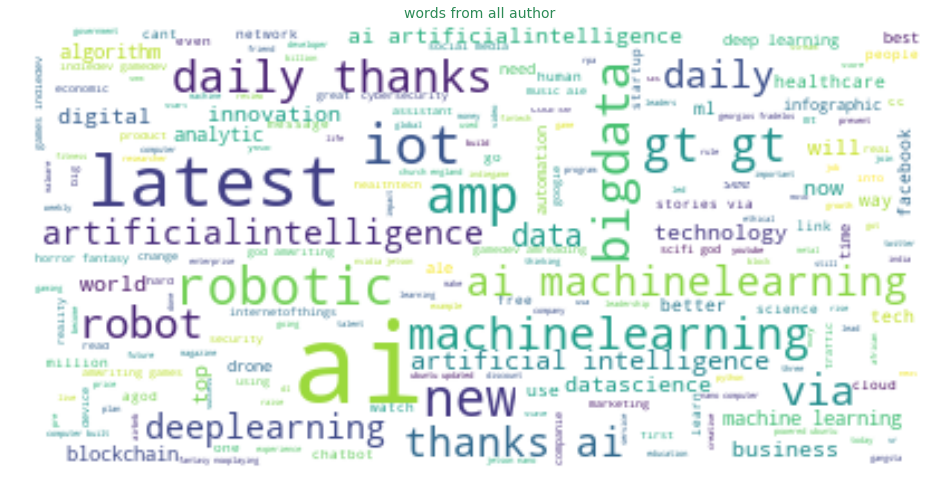

In [27]:
#mws = df_cleaner["text"].values

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)
# generate word cloud
wc.generate(" ".join(df_cleaner.text.values))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14,color='seagreen')
plt.axis("off")

# 2.3 Masking the wordcloud <a id='masking_wordcloud'></a>

[Back to top](#wordclouds)

In [28]:
def base_64(input_image):
    """ Function to convert the image to base64 """
    image = open(input_image, 'rb') #open binary file in read mode 
    image_read = image.read()
    output_base64 = base64.encodebytes(image_read)
    return output_base64

In [29]:
def codecs_img(input_image,base64_image):
    """Generate the Mask for EAP """
    f1 = open(input_image, "wb")
    f1.write(codecs.decode(base64_image,'base64'))
    f1.close()
    img1 = imageio.imread(input_image)
    #img = img1.resize((980,1000))
    #imgplot=plt.imshow(img1)
    #plt.show()
    hcmask=img1
    return hcmask 

In [30]:
mask = base_64('mask.png')
img1 = base_64('1.png')
img2 = base_64('2.png')
img3 = base_64('3.png')
img4 = base_64('4.png')

In [31]:
hcmask1 = codecs_img('mask.png' , mask)
hcmask2 = codecs_img('1.png' , img1)
hcmask3 = codecs_img('2.png' , img2)
hcmask4 = codecs_img('3.png' , img3)
hcmask5 = codecs_img('4.png' , img4)

Updating the stopwords because data from twitter has a few terms which appear over and over again, 
which have no relevance to our text like 'gt' which is an acronym for go to, it is added before a link, 
so along with removing links, we must also remove these words

In [32]:
Stopwords_Updated = ('amp', 'gt', 'via' ,'de')

In [33]:
STOPWORDS=STOPWORDS.union(Stopwords_Updated)

In [34]:
mask = df_cleaner['text'].values

In [35]:
def generate_wordcloud(words, mask):
    """ Generating Word Clouds """
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask, max_font_size= 45).generate(" ".join(words))
    plt.figure(figsize=(10,8))
    image_colors = ImageColorGenerator(mask)
    plt.imshow(word_cloud, interpolation='bilinear') # interpolation(helps in masking)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    

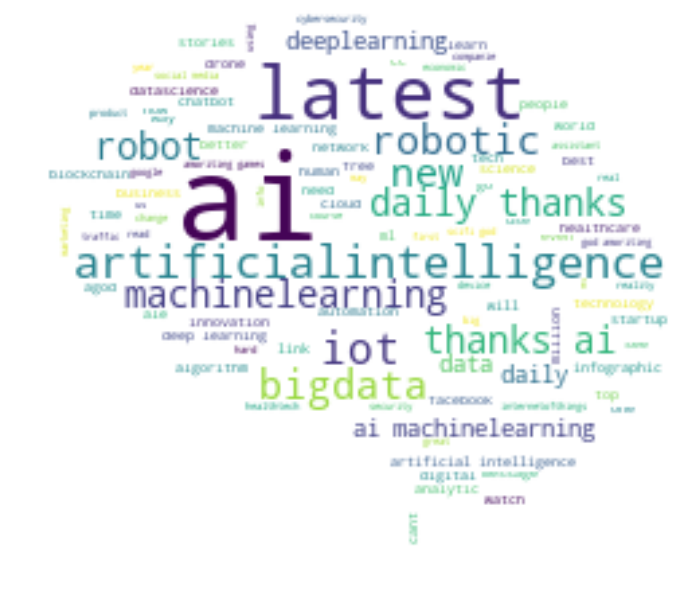

In [36]:
generate_wordcloud(mask,hcmask1)

# 2.4 Preparing Wordclouds <a id='preparing_wordcloud'></a>

[Back to top](#wordclouds)

In [37]:
def generate_wordclouds_gif(words, mask, wc_list):
    """ Generating Word Clouds """
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask, max_font_size= 45).generate(" ".join(words))
    wc_list.append(word_cloud)
    return wc_list

In [44]:
%%capture
wc_list=[]
generate_wordclouds_gif(mask, hcmask2, wc_list)
generate_wordclouds_gif(mask, hcmask3, wc_list)
generate_wordclouds_gif(mask, hcmask4, wc_list)
generate_wordclouds_gif(mask, hcmask5, wc_list)

# 2.5 Function for Building a GIF <a id='gif_building'></a>

[Back to top](#wordclouds)

In [45]:
start = time.time()
def build_gif(imgs = wc_list, show_gif=False, save_gif=True, title=''):
    """function to create a gif of heatmaps"""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(21,15))
    ax.set_axis_off()
    author_range = ["A", "B", "C", "D", "E", "F"]
    def show_im(pairs):
        ax.clear()
        ax.set_title(str((pairs[0])))
        ax.imshow(pairs[1])
        ax.set_axis_off() 
    pairs = list(zip(author_range, imgs))
    im_ani = matplotlib.animation.FuncAnimation(fig, show_im, pairs,interval=450, repeat_delay=0, blit=False, repeat=True)
    plt.cla()
    from IPython.display import HTML
    HTML(im_ani.to_html5_video())
    if save_gif:
        im_ani.save('animation1.gif', writer='pillow') #, writer='imagemagick'
    if show_gif:
        plt.show()
    return
end = time.time()
print("Time taken by above cell is {}".format(end-start))

Time taken by above cell is 0.00018286705017089844


In [62]:
%%capture
start = time.time()
build_gif()
end = time.time()
print(end-start)

RuntimeError: Requested MovieWriter (ffmpeg) not available


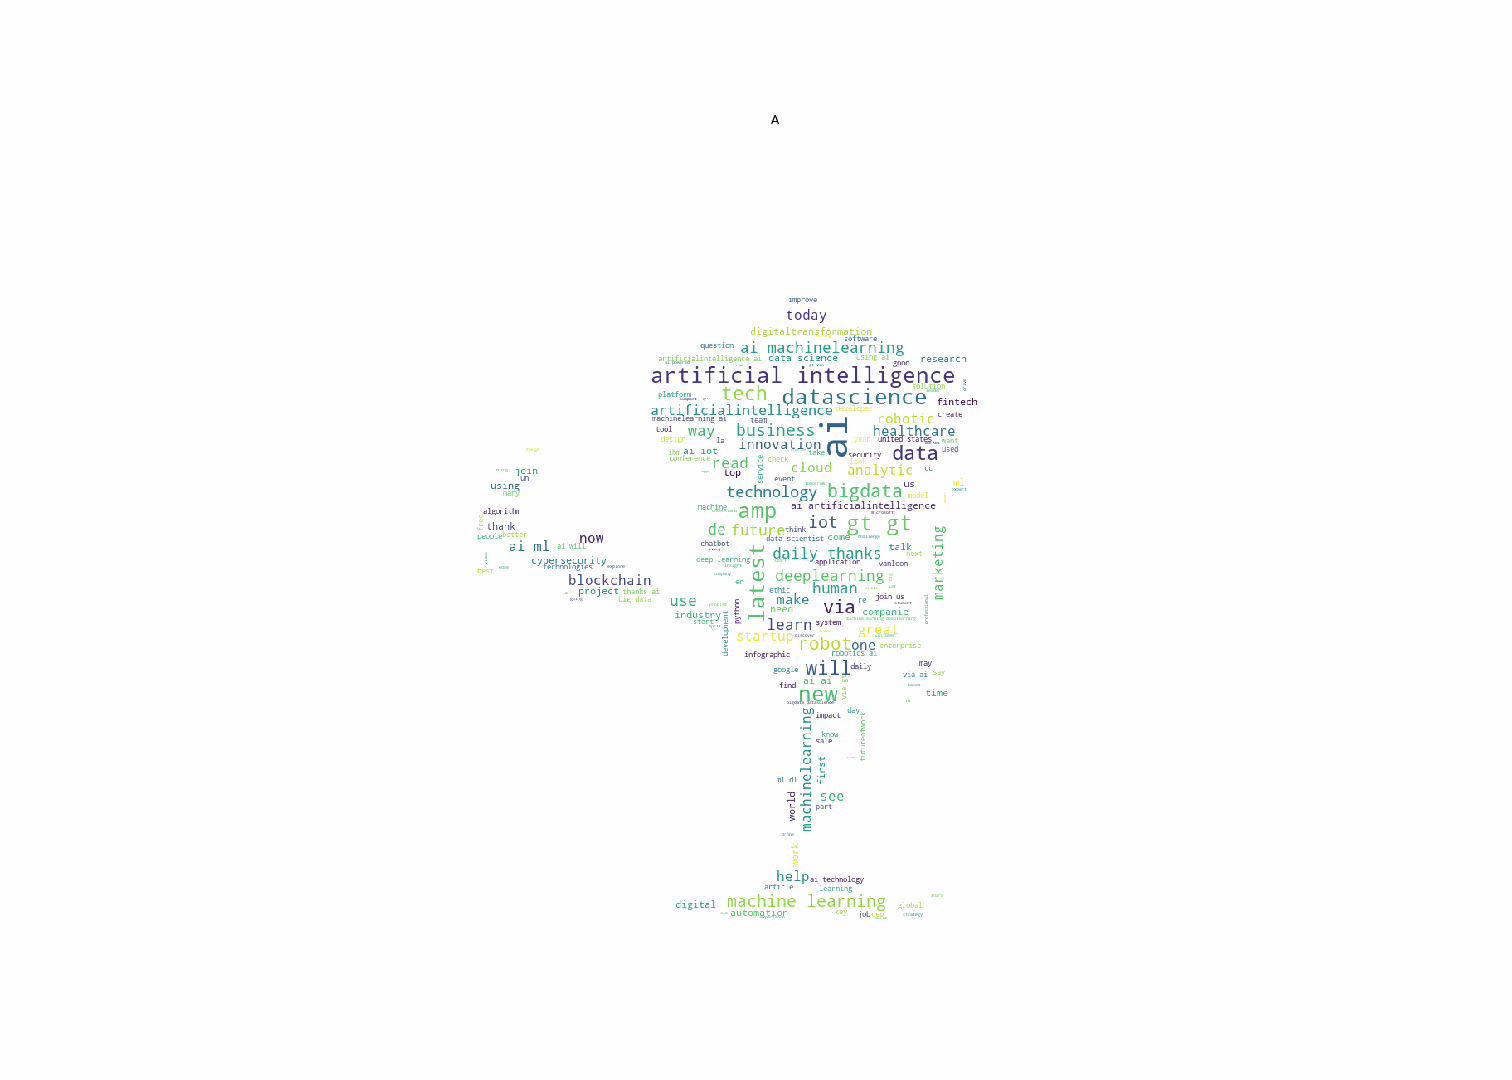

In [154]:
filename = 'animation1.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

# <p style="text-align: center;"> 3.0 LSTM</p> <a id='lstm'></a>



[Back to top](#Introduction)

A language model can predict the probability of the next word in the sequence, based on the words already observed in the sequence.

**Neural network models** are a preferred method for developing statistical language models because they can use a distributed representation where different words with similar meanings have similar representation and because they can use a large context of recently observed words when making predictions.

In this section, we will develop a simple LSTM network to learn sequences of characters from the tweets we scrapped. In the next section we will use this model to generate new sequences of words.

But Before that lets look at how LSTM works. 

A **recurrent neural network** (RNN) is a class of artificial neural network where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task. Sometimes we only want to look at the current information (recent) to perform present task and past information is of not much use to our result, but in case of language modeling , where context is important at times and not important at other times the situation becomes trickier. In cases , where the gap between relevant information and the place where it's needed is small, RNN are useful because they can learn to use past information. But there are also cases where we need more context, the gap becomes large between two informations, RNNs is unable to learn to connect the information. **And that's when LSTM comes in play**


![rnn](RNN.png)

**Long Short Term Memory** networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior

### All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.***

![simplernn](SimpleRnn.png)

### LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.***



![Lstm](Lstm.png)

### How LSTM Works?

**Lets first look at the notations used in the chain like structure(it's not that complex)**
![notation](notation.png)

In the above diagram, each line carries an entire vector, from the output of one node to the inputs of others. 
> **Pink circles** represent pointwise operations, like vector addition

> **Yellow boxes** are learned neural network layers.

> **Lines** merging denote concatenation

> **Line** forking denote its content being copied and

> The **copies** going to different locations


LSTM is a chain like structure containing various cells , each represented by green box in above diagram. The most important thing in LSTMs is the cell state i.e the horizontal line running through the top of the diagram. The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

![LSTM-1](LSTM3-C.png)
The LSTM does has the ability to remove or add information to the cell state, carefully regulated by structures called gates. Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation. The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”

![LSTM-2](LSTM3-gate.png)
An LSTM has three of these gates, to protect and control the cell state.

#### Step by Step LSTM 
1. The first step in LSTM is to decide what information we are going to discard from the cell state. This decison is made by sigmoid layer. It looks at ***ht-1 and xt***, and outputs a number between 0 and 1 for each number in the cell state ***Ct−1***. 
> 1 represents “keep this” while a 0 represents “get rid of this.”

![LSTM-3](LSTM3-f.png)

2. The next step is to decide what new information we’re going to store in the cell state. This has two parts. 

>First, a sigmoid layer called the “input gate layer” decides which values we’ll update and which we will reject. 

>Next, a tanh layer creates a vector of new values, **C̃t**, that could be added to the new state. 

![LSTM-4](LSTM3-I.png)

**Next step, combine these two to create an update to the state.**


3. Then we update the old cell state, **Ct−1**, into the new cell state **Ct**. 

We multiply the old state by **ft**, forgetting the things we decided to forget earlier. Then we add **it∗C̃t** . This is the new values, scaled by how much we decided to update each state value.

![LSTM-5](LSTM-C.png)


4. Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

![LSTM-6](LSTMo.png)


### Lets work it out!! Lets try making a model based on LSTM

In [49]:
from IPython.display import HTML
from IPython.display import Image
Image(url= "https://media1.tenor.com/images/7dcc0b5a2c64d741b6edd12a88738cf9/tenor.gif?itemid=4767352")

The language model will be statistical and will predict the probability of each word given an input sequence of text. The predicted word will be fed in as input to in turn generate the next word.

A key design decision is how long the input sequences should be. They need to be long enough to allow the model to learn the context for the words to predict. This input length will also define the length of seed text used to generate new sequences when we use the model.


# 3.1 Creating character/word mappings <a id='char_and_word_mapping'></a>

[Back to top](#lstm)

We need to transform the raw text into a sequence of tokens or words that we can use as a source to train the model.
We will be removing following from our given input texts

> 1. Replace ‘–‘ with a white space so we can split words better.
> 2. Split words based on white space.
> 3. Remove all punctuation from words to reduce the vocabulary size (e.g. ‘What?’ becomes ‘What’).
> 4. Remove all words that are not alphabetic to remove standalone punctuation tokens.
> 5. Normalize all words to lowercase to reduce the vocabulary size.

Vocabulary size is a big deal with language modeling. A smaller vocabulary results in a smaller model that trains faster.

#### We can run this cleaning operation on our loaded document and print out some of the tokens

In [53]:
import string
 
# turn a doc into clean tokens
def clean_doc(row):
    # replace '--' with a space ' '
    text = row['text']
    text = text.replace('--', ' ')
    # split into tokens by white space
    tokens = text.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens



In [54]:
df_cleaner['token'] = df_cleaner.apply(lambda row: clean_doc(row), axis =1)
#loaded document as an argument and returns an array of clean tokens.

In [55]:
df_cleaner.head()

,text,word_count,token
0,this alphabet owned company is delivering espr...,16,"[this, alphabet, owned, company, is, deliverin..."
1,the latest the keysignals daily socialmedia ai,7,"[the, latest, the, keysignals, daily, socialme..."
2,we need something that can combine machinelear...,17,"[we, need, something, that, can, combine, mach..."
3,raises 80m seriese led by and expansion capita...,9,"[raises, seriese, led, by, and, expansion, cap..."
4,squidoo news soy s twitter pals is out stories...,12,"[squidoo, news, soy, s, twitter, pals, is, out..."


# 3.2 Creating set of words <a id='creating_set_words'></a>


[Back to top](#lstm)







In [56]:
#creating a set of all words in the text columns
def list_creation(list_trial):
    list_trial=list_trial.tolist()
    result_trial = set(x for l in list_trial for x in l)
    #print (result_set)
    return (result_trial)   

In [57]:
df_tokens=list_creation(df_cleaner['token'])
df_tokens_=set(df_tokens)
print('Total Tokens: %d' % len(df_tokens))
print('Unique Tokens: %d' % len(df_tokens_))

Total Tokens: 1516
Unique Tokens: 1516


# 3.3 Creating sequences <a id='creating_sequences'></a>

We are training a statistical language model from the prepared data. It has a few unique characteristics:

> 1. It uses a distributed representation for words so that different words with similar meanings will have a similar representation. 
> 2. It learns the representation at the same time as learning the model. 
> 3. It learns to predict the probability for the next word using the context of the last 100 words. 

We will be using the concept of an Embedding Layer to learn the representation of words, and a Long Short-Term Memory (LSTM) recurrent neural network to learn to predict words based on their context.Steps are as follow

1. Firstly we will be organizing the long list of tokens into sequences of n input words and 1 output word.  That is, sequences of n+1 words. We can do this by iterating over the list of tokens from token n+1 onwards and taking the prior n tokens as a sequence, then repeating this process to the end of the list of tokens. For our example we will be using a sequence of 11 words

[Back to top](#lstm)

In [58]:
# organize into sequences of tokens
length = 11 + 1
sequences = list()
df_tokens=list(df_tokens)
for i in range(length, len(df_tokens)):
    # select sequence of tokens
    seq = df_tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
#use sequences for modeling

Total Sequences: 1504


# 3.4 Saving Tokens  and Loading Tokens <a id='Saving_Tokens'></a>
## One Dialog per line


[Back to top](#lstm)

In [59]:
# save tokens to file, one dialog per line 

def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
## loads tokens to file, one dialog per line 
def load_doc(filename):
# open the file as read only
    file = open(filename, 'r')
# read all text
    text = file.read()
# close the file
    file.close()
    return text


In [60]:
out_filename = 'republic_sequences.txt'
save_doc(sequences, out_filename)

In [61]:
# load
in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')


# 3.5 Integer Encoding Sequences <a id='Integer_Encoding'></a>


[Back to top](#lstm)

The word embedding layer expects input sequences to be comprised of integers. We can map each word in our vocabulary to a unique integer and encode our input sequences. Later, when we make predictions, we can convert the prediction to numbers and look up their associated words in the same mapping.

To do this encoding, we will use the Tokenizer class in the Keras API.

>1. First, the Tokenizer must be trained on the entire training dataset, which means it finds all of the unique words in the data and assigns each a unique integer.

>2. We can then use the fit Tokenizer to encode all of the training sequences, converting each sequence from a list of words to a list of integers.

In [64]:
from keras.preprocessing.text import Tokenizer
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

#### We can access the mapping of words to integers as a dictionary attribute called word_index on the Tokenizer object.  We need to know the size of the vocabulary for defining the embedding layer later. We can determine the vocabulary by calculating the size of the mapping dictionary.

In [65]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1


In [35]:
import numpy as np
sequences = np.asarray(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
seq_length = X.shape[1]

In [36]:
y = np_utils.to_categorical(y, num_classes=vocab_size)

# 3.6 Defining the Model <a id='defining_model'></a>


[Back to top](#lstm)

In [37]:
# define model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11, 50)            41100     
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 822)               83022     
Total params: 275,022
Trainable params: 275,022
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
%%capture
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
MODEL=model.fit(X, y, batch_size=128, epochs=100)


In [ ]:
# save the model to file
from json import dumps, loads
model.save('model.h5')
# save the tokenizer
import pickle
output = open('myfile.pkl', 'wb')
pickle.dump(tokenizer, output)
output.close()




In [ ]:
#Use Language Model
#in_filename = 'republic_sequences.txt'
#doc = load_doc(in_filename)
#lines = doc.split('\n')

In [ ]:
#pkl_file = open('tokenizer.pkl', 'rb')
#mydict2 = pickle.load(pkl_file)
#pkl_file.close()
seq_length = len(lines[0].split()) - 1

In [457]:
from random import randint
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

smith supermarket bills growth artifi ki disease helped consists months daimler countrys



In [458]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
    # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
    # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
    # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
    # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
    # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [459]:
from keras.preprocessing.sequence import pad_sequences
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

biggest jeff hour event might cars philosophy analysis hybrid flyingcars valeo orchestrate packed vielen real available president stars gebied anticipated inteligenciaartificial unemployment kitchen eye thrones activities schwchen wollen lata pursuing war encore internal thats h ago emerged milan says segunda mquinas earbuds bollmoor hospitals page talentacquisition convergenttechnologies supplychain conceived diy


In [59]:
# characters = sorted(list(set(df_cleaner['text'])))
# n_to_char = {n:char for n, char in enumerate(characters)}
# char_to_n = {char:n for n, char in enumerate(characters)}
# #All unique characters are first stored in characters and are then enumerated.
# #However, when compared with each other, a word-based model shows much higher accuracy as compared to a 
# #character-based model. This is because the latter model requires a much larger network to learn 
# #long-term dependencies as it not only has to remember the sequences of words, 
# #but also has to learn to predict a grammatically correct word. However, in case of a word-based model, 
# #the latter has already been taken care of.

In [255]:
df_cleans.head()
df_cleans.to_csv("new.csv", index=False)

In [ ]:
import sys
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
# load ascii text and covert to lowercase
doc = load_doc(in_filename)
lines = doc.split('\n')
# create mapping of unique chars to integers, and a reverse mapping
chars = sorted(list(set(doc)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(doc)
n_vocab = len(chars)
print ("Total Characters: ", n_chars)
print ("Total Vocab: ", n_vocab)


In [ ]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 10
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = doc[i:i + seq_length]
    seq_out = doc[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)


In [ ]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)


In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

In [ ]:
# load the network weights
filename = "weights-improvement-20-0.4177.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print ("\nDone.")

# <p style="text-align: center;">Conclusion<p><a id='Conclusion'></a>



[Back to top](#Introduction)

[Sentiment Analysis](Sentiment_Analysis.ipynb)

# <p style="text-align: center;">Contribution<p><a id='Contribution'></a>

    
- Code by self : 60%
- Code from external Sources : 40%

[Back to top](#Introduction)

# Citation:
1. https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/code/preprocess.py
2. https://stackoverflow.com/questions/8282553/removing-character-in-list-of-strings
3. https://github.com/bear/python-twitter/blob/master/twitter/parse_tweet.py
4. https://gist.github.com/dreikanter/2787146
5. https://docs.python.org/3.4/howto/unicode.html
6. https://www.kaggle.com/eliasdabbas/extract-entities-from-social-media-posts

[Back to top](#Introduction)

# <p style="text-align: center;">License<p><a id='License'></a>
Copyright (c) 2019 Manali Sharma, Rushabh Nisher

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

[Back to top](#Introduction)